In [1]:
import yfinance as yf
import pandas as pd
import os
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.stats import bernoulli

@dataclass
class Candle:
    open: float
    high: float
    close: float
    low: float
    index: int

@dataclass
class Stats:
    num_trades: int
    win_rate: float
    num_wins: int
    num_losses: int
    perc_return: float
    perc_buy_hold_return: float
    initial_cash: float
    total_profit: float

    def __repr__(self) -> str:
        return f"""
        Number of Trades: {self.num_trades}
        Win Rate: {self.win_rate}%
        Return [%] : {self.perc_return}%
        Buy and Hold Return [%]: {self.perc_buy_hold_return}%
        Total Profit: ${self.total_profit}
        Initial Capital: ${self.initial_cash}
        Winning Trades: {self.num_wins}
        Losing Trades: {self.num_losses}
        """


class Trade:
    def __init__(self, buy_price, buy_index, profit_perc, stop_loss_perc):

        self.buy_price = buy_price
        self.sell_price = None
        self.profit = None

        self.buy_index = buy_index
        self.sell_index = None

        self.profit_perc = profit_perc
        self.stop_loss_perc = stop_loss_perc

        self.is_closed = False

        self.take_profit_val = None
        self.take_stop_loss_val = None

        self.update()

    def update(self, curr_candle=None):

        self.take_profit_val = self.buy_price * (1 + self.profit_perc)
        self.take_stop_loss_val = self.buy_price * (1 - self.stop_loss_perc)

    def try_to_close(self, curr_candle):
        if self.is_closed:
            return False

        if curr_candle.low < self.take_stop_loss_val:
            self.close_trade(self.take_stop_loss_val, curr_candle.index)
            return True
        elif curr_candle.high > self.take_profit_val:
            self.close_trade(self.take_profit_val, curr_candle.index)
            return True

        return False


    def close_trade(self, sell_price, sell_index):
        self.sell_price = sell_price
        self.sell_index = sell_index
        self.profit = self.sell_price - self.buy_price

        self.is_closed = True


class BaseStrategy:
    def __init__(self, cash):
        self.all_trades = []
        self.cash = cash
        self.init_cash = cash
        # For buy and hold calculation
        self.init_buy_price = None
        self.buy_hold_cash = None
        self.final_buy_price = None

        self.final_stats = None


    def buy(self, buy_price, buy_index, profit_perc, stop_loss_perc):
        if buy_price > self.cash:
            return

        new_trade = Trade(buy_price, buy_index, profit_perc, stop_loss_perc)
        self.all_trades.append(new_trade)
        self.cash -= buy_price

    def _update_buy_hold_stats(self, curr_candle):
        if not self.init_buy_price:
            self.init_buy_price = curr_candle.open
            self.buy_hold_cash = self.cash - self.init_buy_price

        self.final_buy_price = curr_candle.close


    def run(self, curr_candle, row=None):
        self._update_buy_hold_stats(curr_candle)

        #raise ValueError("Must be implemented by other strategies")

    def force_close(self, curr_candle, row=None):
        for tr in self.all_trades:
            if not tr.is_closed:
                tr.close_trade(sell_price=curr_candle.close, sell_index=curr_candle.index)


    def get_stats(self):
        closed_trades = [tr for tr in self.all_trades if tr.is_closed]
        num_trades = len(closed_trades)
        num_wins = len([tr for tr in closed_trades if  tr.profit > 0])
        total_profit = sum([tr.profit for tr in closed_trades])
        if num_trades > 0:
            win_rate=(num_wins/num_trades) * 100.0
        else:
            win_rate = 0.0

        perc_return = total_profit*100.0/ self.init_cash
        perc_buy_hold_return = ((self.final_buy_price + self.buy_hold_cash) - self.init_cash)*100.0 / self.init_cash


        self.final_stats = Stats(
            num_trades=num_trades,
            num_wins=num_wins,
            num_losses=(num_trades - num_wins),
            win_rate=round(win_rate, 3),
            total_profit=total_profit,
            perc_return= round(perc_return, 3),
            initial_cash=self.init_cash,
            perc_buy_hold_return=round(perc_buy_hold_return, 3)
        )



class RandomStrategy(BaseStrategy):
    def __init__(self, cash):
        super().__init__(cash)

    def run(self, curr_candle, row):
        super().run(curr_candle, row)

        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price

        curr_rv = self._get_random_num(state=curr_candle.index)
        if curr_rv:
            self.buy(
                buy_price = curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc = 0.01,
                stop_loss_perc = 0.01,
            )

    def _get_random_num(self, prop=0.5, state=42):
        this_rv = bernoulli.rvs(prop, loc=0, size=1, random_state = state)[0]
        if this_rv == 1:
            return True
        else:
            return False


class MLStrategy(BaseStrategy):
    def __init__(self, cash, model, predictors):
        super().__init__(cash)
        self.model = model
        self.predictors = predictors
        self.current_prediction = None
        
    def run(self, curr_candle, row):
        super().run(curr_candle, row)
        
        # First check and close any existing trades
        for tr in self.all_trades:
            close_curr = tr.try_to_close(curr_candle)
            if close_curr:
                self.cash += tr.sell_price
        
        # Make prediction using the model
        features = row[self.predictors].values.reshape(1, -1)
        pred_proba = self.model.predict_proba(features)[:,1]
        prediction = 1 if pred_proba >= 0.6 else 0
        self.current_prediction = prediction
        
        # If model predicts price will go up (1) and we have enough cash, place a trade
        if prediction == 1:
            self.buy(
                buy_price=curr_candle.open,
                buy_index=curr_candle.index,
                profit_perc=0.01,  # 1% target profit
                stop_loss_perc=0.01,  # 1% stop loss
            )


def candlestick_ax(t, o, h, l, c):
    t_index = list(range(len(t)))

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    color = ["green" if close_price > open_price else "red" for close_price, open_price in zip(c, o)]
    ax.bar(x=t_index, height=h-l, bottom=l, width=0.1, color=color)
    ax.bar(x=t_index, height=np.abs(o-c), bottom=np.min((o,c), axis=0), width=0.6, color=color)


    t_loc = t_index[::72]
    #if type(t[0]) == datetime or type(t[0]) == pd._libs.tslibs.timestamps.Timestamp:
    #    label_loc = [datetime.strftime(x, '%H-%M') for x in t[::12]]
    label_loc = [x[:10] for x in t[::72]]
    ax.set_xticks(ticks=t_loc, labels=label_loc, rotation=45);

    return ax


class BackTest:
    def __init__(self, df, strategy):
        self.df = df
        self.strategy = strategy

    def run_test(self):
        for index, row in self.df.iterrows():
            curr_candle = Candle(open=row['Open'], close=row['Close'], high=row['High'], low=row['Low'], index=row['time_index'])
            self.strategy.run(curr_candle, row)
        self.strategy.force_close(curr_candle, row)

    def show_stats(self):
        self.strategy.get_stats()
        print(self.strategy.final_stats)


    def visualize(self, verbose=False):
        buy_list =[
            {'buy_time': tr.buy_index, 'sell_time': tr.sell_index, 'buy_price': tr.buy_price, 'sell_price': tr.sell_price,
             'profit': tr.profit}
            for tr in self.strategy.all_trades
        ]
        buy_sell_df = pd.DataFrame(buy_list)
        buy_sell_loss_df = buy_sell_df.query("profit<0")

        if verbose:
            print(buy_sell_df)

        _ax = candlestick_ax(t=self.df['time_str'], o=self.df['Open'], h=self.df['High'], l=self.df['Low'], c=self.df['Close'])
        _ax.plot(buy_sell_df['buy_time'], buy_sell_df['buy_price'], marker=".", markersize=40, color='g', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_df['sell_time'], buy_sell_df['sell_price'], marker=".", markersize=40, color='r', alpha=0.3, linestyle="None")
        _ax.plot(buy_sell_loss_df['sell_time'], buy_sell_loss_df['sell_price'], marker="x", markersize=20, color='k', alpha=0.3, linestyle="None")

        return _ax




In [3]:
info_path = Path(os.path.join(os.getcwd(), f"resources/sp50e0.csv"))
if os.path.exists(info_path):
    sp500 = pd.read_csv(info_path, index_col=0)
else:
    sp500 = yf.download('GC=F', period="730d", interval='1h', ignore_tz = True, progress=False)
    # sp500.to_csv("sp500.csv")

In [4]:
sp500.index = pd.to_datetime(sp500.index, utc=True).map(lambda x: x.tz_convert('Singapore'))
sp500.columns = sp500.columns.droplevel(1)

In [5]:
display(sp500.tail(30))

Price,Close,High,Low,Open,Volume
Datetime,,,,,
2025-01-27 12:00:00+08:00,2768.100098,2770.500000,2760.199951,2761.500000,6668
2025-01-27 13:00:00+08:00,2772.300049,2775.800049,2767.300049,2768.000000,13524
2025-01-27 14:00:00+08:00,2776.000000,2776.399902,2769.500000,2772.199951,8964
2025-01-27 15:00:00+08:00,2766.399902,2776.500000,2765.300049,2776.000000,8997
2025-01-27 16:00:00+08:00,2761.300049,2767.300049,2756.399902,2766.399902,21301
2025-01-27 17:00:00+08:00,2754.600098,2762.000000,2747.699951,2761.199951,24518
2025-01-27 18:00:00+08:00,2745.000000,2754.699951,2742.100098,2754.699951,20487
2025-01-27 19:00:00+08:00,2736.800049,2746.699951,2734.699951,2744.899902,23348
2025-01-27 20:00:00+08:00,2735.600098,2739.100098,2732.000000,2736.899902,17525


<Axes: xlabel='Datetime'>

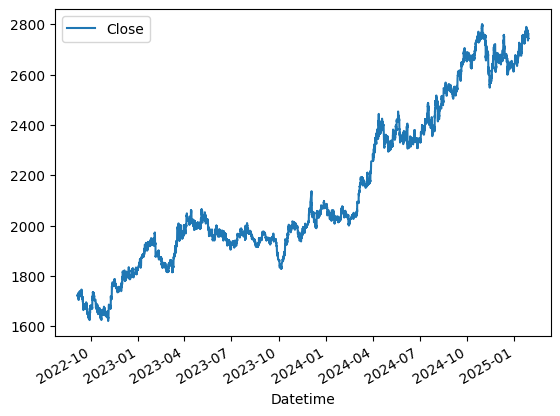

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
# del sp500["Dividends"]
# del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-3)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [10]:
sp500 = sp500.loc["1990-01-01":].copy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-110]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [12]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5283018867924528

<Axes: xlabel='Datetime'>

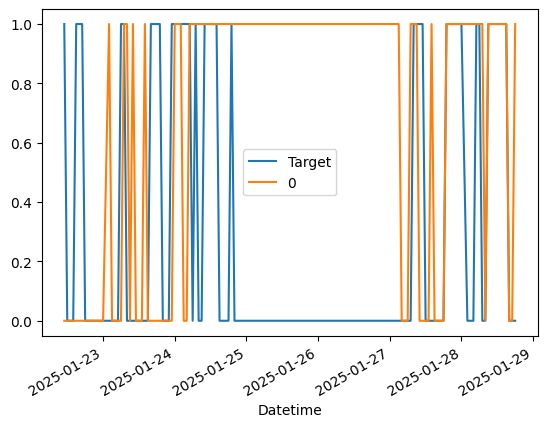

In [13]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [15]:
def backtest(data, model, predictors, start=2400, step=240):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i-10].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [16]:
predictions = backtest(sp500, model, predictors)

In [17]:
predictions["Predictions"].value_counts()

Predictions
0    6185
1    5171
Name: count, dtype: int64

In [18]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5144072713208276

In [19]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.510655
0    0.489345
Name: count, dtype: float64

In [20]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [21]:
# sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500 = sp500.dropna()

In [22]:
sp500

Price,Close,High,Low,Open,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Datetime,,,,,,,,,,,,,,,,,
2022-11-04 13:00:00+08:00,1648.500000,1654.800049,1646.400024,1650.400024,11216,1662.599976,1,0.999424,2.0,0.999697,3.0,1.003495,33.0,0.998775,119.0,0.983122,480.0
2022-11-04 14:00:00+08:00,1652.099976,1655.500000,1647.800049,1648.400024,9576,1670.500000,1,1.001091,2.0,1.001552,4.0,1.005679,34.0,1.000920,119.0,0.985308,480.0
2022-11-04 15:00:00+08:00,1654.099976,1656.199951,1651.800049,1652.099976,10389,1676.500000,1,1.000605,2.0,1.002205,4.0,1.006865,35.0,1.002120,119.0,0.986540,480.0
2022-11-04 16:00:00+08:00,1662.599976,1663.400024,1642.800049,1654.099976,39764,1674.300049,1,1.002563,2.0,1.005479,5.0,1.011908,35.0,1.007229,120.0,0.991645,480.0
2022-11-04 17:00:00+08:00,1670.500000,1671.199951,1661.800049,1662.400024,42690,1676.500000,1,1.002370,2.0,1.007807,5.0,1.016503,35.0,1.011941,121.0,0.996388,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28 11:00:00+08:00,2744.899902,2745.500000,2737.399902,2742.500000,6997,2746.699951,1,1.000510,2.0,1.000357,3.0,0.993071,27.0,1.002170,122.0,1.022794,516.0
2025-01-28 12:00:00+08:00,2747.300049,2749.100098,2744.100098,2744.800049,5527,2749.300049,1,1.000437,2.0,1.001049,3.0,0.994040,28.0,1.002986,123.0,1.023655,516.0
2025-01-28 13:00:00+08:00,2747.300049,2749.600098,2745.000000,2747.300049,4925,2753.600098,1,1.000000,2.0,1.000874,4.0,0.994134,29.0,1.002916,124.0,1.023622,516.0


In [23]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.8] = 1
    preds[preds <.8] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [25]:
predictions = backtest(sp500, model, new_predictors)

In [26]:
predictions["Predictions"].value_counts()

Predictions
0.0    9447
1.0     906
Name: count, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])

0.8576158940397351

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.512508
0    0.487492
Name: count, dtype: float64

In [29]:
predictions

,Target,Predictions
Datetime,,
2023-04-10 23:00:00+08:00,1,0.0
2023-04-11 00:00:00+08:00,1,1.0
2023-04-11 02:00:00+08:00,0,1.0
2023-04-11 03:00:00+08:00,1,0.0
2023-04-11 04:00:00+08:00,1,0.0
...,...,...
2025-01-28 11:00:00+08:00,1,0.0
2025-01-28 12:00:00+08:00,1,0.0
2025-01-28 13:00:00+08:00,1,1.0


In [31]:
sp500['time_index'] = range(len(sp500))

In [ ]:
# Initialize the strategy
strategy = MLStrategy(cash=10000, model=model, predictors=new_predictors)

# Create and run backtest
backtest = BackTest(df=sp500, strategy=strategy)
backtest.run_test()
backtest.show_stats()

/Users/joshualeow/Documents/Projects/IPOStocksAnalysis/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/joshualeow/Documents/Projects/IPOStocksAnalysis/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/joshualeow/Documents/Projects/IPOStocksAnalysis/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/joshualeow/Documents/Projects/IPOStocksAnalysis/env/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/joshualeo

In [33]:
backtest.visualize()

KeyError: 'time_str'